In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from scipy import stats
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('/work/DM2425_ABCDEats_DATASET (1).csv')

# Strip trailing spaces from column names
df.columns = df.columns.str.strip()
df.columns


/tmp/ipykernel_642/2776257542.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/work/DM2425_ABCDEats_DATASET (1).csv')


Index(['customer_id', 'customer_region', 'customer_age', 'vendor_count',
       'product_count', 'is_chain', 'first_order', 'last_order', 'last_promo',
       'payment_method', 'CUI_American', 'CUI_Asian', 'CUI_Beverages',
       'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts',
       'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese',
       'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks',
       'CUI_Thai', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5',
       'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7',
       'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15',
       'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23'],
      dtype='object')

### PREPROCCESING


In [3]:
df.head(50);

In [4]:
#Check for duplicates
df.duplicated().sum()


13

In [5]:
#Drop duplicates
df.drop_duplicates(inplace=True)

In [6]:
def fix_hr0(df):
    """
    Fix HR_0 values by comparing total DOW orders with sum of HR orders.
    If there's a mismatch, assign missing orders to HR_0.
    """
    # Calculate total orders from DOW columns
    dow_cols = ['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6']
    total_dow_orders = df[dow_cols].sum(axis=1)
    
    # Calculate total orders from HR columns (excluding HR_0)
    hr_cols = [f'HR_{i}' for i in range(1, 24)]  # HR_1 to HR_23
    total_hr_orders = df[hr_cols].sum(axis=1)
    
    # Calculate missing orders
    missing_orders = total_dow_orders - total_hr_orders
    
    # Update HR_0 with missing orders where the difference is positive
    df['HR_0'] = np.where(missing_orders > 0, missing_orders, 0)
    
    # Print summary of changes
    total_fixed = (missing_orders > 0).sum()
    total_orders_added = missing_orders[missing_orders > 0].sum()
    
    print(f"Fixed {total_fixed} rows")
    print(f"Added {total_orders_added} orders to HR_0")
    print("\nVerification:")
    print(f"Total DOW orders: {total_dow_orders.sum()}")
    print(f"Total HR orders after fix: {df[['HR_' + str(i) for i in range(24)]].sum().sum()}")
    
    return df

# Apply the fix
df = fix_hr0(df)

Fixed 1164 rows
Added 1552 orders to HR_0

Verification:
Total DOW orders: 139263
Total HR orders after fix: 139263


In [7]:
df['customer_age'] = pd.to_numeric(df['customer_age'], errors='coerce').astype('Int64')
df['first_order'] = pd.to_numeric(df['first_order'], errors='coerce').astype('Int64')
df['HR_0'] = pd.to_numeric(df['HR_0'], errors='coerce').astype('Int64')

# Verify the changes
print(df[['customer_age', 'first_order', 'HR_0']].dtypes)


customer_age    Int64
first_order     Int64
HR_0            Int64
dtype: object


In [8]:
# Check for null values in entire dataframe
df.isna()  # or df.isnull()
df.isna().sum()  # Count nulls in each column



customer_id                   0
customer_region               0
customer_age                727
vendor_count                  0
product_count                 0
is_chain                      0
first_order                 106
last_order                    0
last_promo                    0
payment_method                0
CUI_American                  0
CUI_Asian                     0
CUI_Beverages                 0
CUI_Cafe                      0
CUI_Chicken Dishes            0
CUI_Chinese                   0
CUI_Desserts                  0
CUI_Healthy                   0
CUI_Indian                    0
CUI_Italian                   0
CUI_Japanese                  0
CUI_Noodle Dishes             0
CUI_OTHER                     0
CUI_Street Food / Snacks      0
CUI_Thai                      0
DOW_0                         0
DOW_1                         0
DOW_2                         0
DOW_3                         0
DOW_4                         0
DOW_5                         0
DOW_6   

In [9]:
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np

def knn_imputation(df, columns=['customer_age', 'first_order'], n_neighbors=5):
    """
    Perform KNN imputation with NA handling
    """
    # Convert NA/None to np.nan
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Create KNN imputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    
    # Perform imputation
    imputed_data = imputer.fit_transform(df[columns])
    
    # Update DataFrame
    for i, column in enumerate(columns):
        df[column] = imputed_data[:, i]
    
    return df

# Example usage:
df = knn_imputation(df)

In [10]:
df['last_promo'].replace('-', 'None')

0        DELIVERY   
1        DISCOUNT   
2        DISCOUNT   
3        DELIVERY   
4        -          
            ...     
31883    FREEBIE    
31884    DELIVERY   
31885    -          
31886    DISCOUNT   
31887    -          
Name: last_promo, Length: 31875, dtype: object

In [11]:
# Check for null values in entire dataframe
df.isna()  # or df.isnull()
df.isna().sum()  # Count nulls in each column

customer_id                 0
customer_region             0
customer_age                0
vendor_count                0
product_count               0
is_chain                    0
first_order                 0
last_order                  0
last_promo                  0
payment_method              0
CUI_American                0
CUI_Asian                   0
CUI_Beverages               0
CUI_Cafe                    0
CUI_Chicken Dishes          0
CUI_Chinese                 0
CUI_Desserts                0
CUI_Healthy                 0
CUI_Indian                  0
CUI_Italian                 0
CUI_Japanese                0
CUI_Noodle Dishes           0
CUI_OTHER                   0
CUI_Street Food / Snacks    0
CUI_Thai                    0
DOW_0                       0
DOW_1                       0
DOW_2                       0
DOW_3                       0
DOW_4                       0
DOW_5                       0
DOW_6                       0
HR_0                        0
HR_1      

In [12]:
# Convert nullable Int64 to regular int64 if you're sure there are no nulls
df['customer_age'] = df['customer_age'].astype('int64')
df['first_order'] = df['first_order'].astype('int64')

# Convert float CUI_ columns to int if they represent counts
cui_columns = [col for col in df.columns if col.startswith('CUI_')]
df[cui_columns] = df[cui_columns].astype('int64')

In [13]:
# Let's examine customers with 0 vendors
zero_vendor_customers = df[df['vendor_count'] == 0]

# Check their other metrics
print("\nStats for customers with 0 vendors:")
print(zero_vendor_customers[['product_count', 'first_order', 'last_order']].describe())

# Check if they have any orders in cuisine types
cui_columns = [col for col in df.columns if col.startswith('CUI_')]
print("\nDo they have any cuisine orders:")
print(zero_vendor_customers[cui_columns].sum())

# Check their regions and payment methods
print("\nTheir regions:")
print(zero_vendor_customers['customer_region'].value_counts())




Stats for customers with 0 vendors:
       product_count  first_order  last_order
count          138.0   138.000000  138.000000
mean             0.0    44.659420   44.659420
std              0.0    25.934645   25.934645
min              0.0     1.000000    1.000000
25%              0.0    22.250000   22.250000
50%              0.0    44.000000   44.000000
75%              0.0    66.750000   66.750000
max              0.0    89.000000   89.000000

Do they have any cuisine orders:
CUI_American                0
CUI_Asian                   0
CUI_Beverages               0
CUI_Cafe                    0
CUI_Chicken Dishes          0
CUI_Chinese                 0
CUI_Desserts                0
CUI_Healthy                 0
CUI_Indian                  0
CUI_Italian                 0
CUI_Japanese                0
CUI_Noodle Dishes           0
CUI_OTHER                   0
CUI_Street Food / Snacks    0
CUI_Thai                    0
dtype: int64

Their regions:
customer_region
8670                

In [14]:
# Remove customers with 0 vendors
print(f"Number of rows after removing 0-vendor customers: {len(df)}")
df = df[df['vendor_count'] > 0]

# Verify the removal
print(f"Number of rows after removing 0-vendor customers: {len(df)}")

# Optional: Reset the index if needed
df = df.reset_index(drop=True)

Number of rows after removing 0-vendor customers: 31875
Number of rows after removing 0-vendor customers: 31737


In [15]:
 #Customer Value Features
# Total monetary value
cuisine_cols = [col for col in df.columns if col.startswith('CUI_')]
df['total_spending'] = df[cuisine_cols].sum(axis=1)
df['total_orders'] = df[[col for col in df.columns if col.startswith('DOW_')]].sum(axis=1)

# Number of different cuisines ordered (variety)
df['cuisine_diversity'] = (df[cuisine_cols] > 0).sum(axis=1)

# Calculate total orders
df['total_orders'] = df[[col for col in df.columns if col.startswith('DOW_')]].sum(axis=1)

# Get primary cuisine (highest spending category)
df['primary_cuisine'] = df[cuisine_cols].idxmax(axis=1).str.replace('CUI_', '')

   # Weekend vs Weekday preference
df['weekend_orders'] = df['DOW_0'] + df['DOW_6']
df['underweekend_orders'] = df['DOW_1'] + df['DOW_2'] + df['DOW_3'] + df['DOW_4'] + df['DOW_5']
df['weekend_ratio'] = df['weekend_orders'] / df['total_orders'].replace(0, 1)


# Peak hours preference (lunch 11-14, dinner 18-21)
lunch_hours = ['HR_11', 'HR_12', 'HR_13']
dinner_hours = ['HR_18', 'HR_19', 'HR_20']

df['lunch_orders'] = df[lunch_hours].sum(axis=1)
df['dinner_orders'] = df[dinner_hours].sum(axis=1)

# Primary meal time preference
df['meal_preference'] = np.where(df['lunch_orders'] > df['dinner_orders'], 'lunch', 'dinner')
    


# Are they ordering throughout the day or only specific times?
morning_hours = ['HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10']
midday_hours = ['HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15']
evening_hours = ['HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20']
night_hours = ['HR_21', 'HR_22', 'HR_23', 'HR_0']
drinking_hours = [ 'HR_1','HR_2', 'HR_3', 'HR_4', 'HR_5']

df['morning_orders'] = df[morning_hours].sum(axis=1)
df['midday_orders'] = df[midday_hours].sum(axis=1)
df['evening_orders'] = df[evening_hours].sum(axis=1)
df['night_orders'] = df[night_hours].sum(axis=1)
df['drinking_orders'] = df[drinking_hours].sum(axis=1)

# Calculate primary time period
time_periods = ['morning_orders', 'midday_orders', 'evening_orders', 'night_orders', 'drinking_orders']
df['primary_time_period'] = df[time_periods].idxmax(axis=1).str.replace('_orders', '')



#New Features: CUI_NewAsian, CUI_NewOther, 
df['CUI_NewAsian']= df['CUI_Japanese'] + df['CUI_Chinese'] + df['CUI_Indian'] + df['CUI_Thai']
df['CUI_NewOther'] = df['CUI_Desserts'] + df['CUI_Cafe'] + df['CUI_Street Food / Snacks'] + df['CUI_Beverages']
#Left: American, Chicken dishes, Healthy, Noodle Dishes, Italian 
          

In [16]:
df.head(10)

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,dinner_orders,meal_preference,morning_orders,midday_orders,evening_orders,night_orders,drinking_orders,primary_time_period,CUI_NewAsian,CUI_NewOther
0,1b8f824d5e,2360,18,2,5,1,0,1,DELIVERY,DIGI,...,2,dinner,0,0,2,0,0,evening,28,0
1,5d272b9dcb,8670,17,2,2,2,0,1,DISCOUNT,DIGI,...,0,lunch,1,1,0,0,0,morning,0,0
2,f6d1b2ba63,4660,38,1,2,2,0,1,DISCOUNT,CASH,...,0,lunch,1,1,0,0,0,morning,0,0
3,180c632ed8,4660,24,2,3,1,0,2,DELIVERY,DIGI,...,0,lunch,0,2,0,0,0,midday,17,0
4,4eb37a6705,4660,20,2,5,0,0,2,-,DIGI,...,0,dinner,2,0,0,0,0,morning,0,0
5,6aef2b6726,8670,40,2,2,0,0,2,FREEBIE,DIGI,...,0,dinner,0,0,0,0,2,drinking,0,0
6,8475ee66ef,2440,24,2,2,2,0,2,-,CARD,...,0,lunch,0,1,1,0,0,midday,0,1
7,f2f53bcc67,8670,27,2,3,2,0,2,DISCOUNT,DIGI,...,0,dinner,1,1,0,0,0,morning,0,24
8,5b650c89cc,2360,20,3,4,2,0,3,DISCOUNT,DIGI,...,1,dinner,0,0,2,1,0,evening,0,0
9,84775a7237,8670,20,2,3,0,0,3,DELIVERY,CARD,...,0,dinner,0,0,0,0,2,drinking,0,0


New Feature: DOW to During work time (e.g. Monday till Friday lunch?) and Weekend

In [17]:
df = df.drop(columns=['customer_id'])

In [19]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Method 1: Using pandas get_dummies (simplest approach)
# Method 2: Using scikit-learn's OneHotEncoder (more flexible)
def encode_with_sklearn(df, categorical_columns):
    # Initialize the encoder
    encoder = OneHotEncoder(drop='first', sparse=False)
    
    # Fit and transform the categorical variables
    encoded_array = encoder.fit_transform(df[categorical_columns])
    
    # Get feature names
    feature_names = encoder.get_feature_names_out(categorical_columns)
    
    # Create DataFrame with encoded variables
    encoded_df = pd.DataFrame(
        encoded_array, 
        columns=feature_names,
        index=df.index
    )
    
    # Combine with non-categorical columns
    result = pd.concat(
        [df.drop(columns=categorical_columns), encoded_df],
        axis=1
    )
    
    return result

hotencoded = encode_with_sklearn(df, df.select_dtypes(include='object').columns)

In [20]:
pd.set_option('display.max_columns', None)
hotencoded.head(10)

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,total_spending,total_orders,cuisine_diversity,weekend_orders,underweekend_orders,weekend_ratio,lunch_orders,dinner_orders,morning_orders,midday_orders,evening_orders,night_orders,drinking_orders,CUI_NewAsian,CUI_NewOther,customer_region_2360,customer_region_2440,customer_region_2490,customer_region_4140,customer_region_4660,customer_region_8370,customer_region_8550,customer_region_8670,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,payment_method_CASH,payment_method_DIGI,primary_cuisine_Asian,primary_cuisine_Beverages,primary_cuisine_Cafe,primary_cuisine_Chicken Dishes,primary_cuisine_Chinese,primary_cuisine_Desserts,primary_cuisine_Healthy,primary_cuisine_Indian,primary_cuisine_Italian,primary_cuisine_Japanese,primary_cuisine_Noodle Dishes,primary_cuisine_OTHER,primary_cuisine_Street Food / Snacks,primary_cuisine_Thai,meal_preference_lunch,primary_time_period_evening,primary_time_period_midday,primary_time_period_morning,primary_time_period_night
0,18,2,5,1,0,1,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,28,2,1,2,0,1.000000,0,2,0,0,2,0,0,28,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,17,2,2,2,0,1,12,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,18,2,2,2,0,1.000000,1,0,1,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,38,1,2,2,0,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,9,2,1,2,0,1.000000,1,0,1,1,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,24,2,3,1,0,2,0,13,0,0,0,0,0,0,17,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,30,2,2,1,1,0.500000,1,0,0,2,0,0,0,17,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,20,2,5,0,0,2,14,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,2,2,1,1,0.500000,0,0,2,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,40,2,2,0,0,2,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,2,1,1,1,0.500000,0,0,0,0,0,0,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,24,2,2,2,0,2,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,6,2,2,1,1,0.500000,1,0,0,1,1,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7,27,2,3,2,0,2,11,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,35,2,2,1,1,0.500000,0,0,1,1,0,0,0,0,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,20,3,4,2,0,3,2,0,0,0,0,0,0,4,0,0,0,0,7,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,13,3,3,2,1,0.666667,0,1,0,0,2,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,20,2,3,0,0,3,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32

In [21]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical features
# Fit and transform the data
scaled_data = scaler.fit_transform(hotencoded)

# Convert back to DataFrame with column names preserved
scaled_df = pd.DataFrame(scaled_data, columns=hotencoded.columns, index=hotencoded.index)

# Verify scaling results
print("Scaling verification:")
print("\nMean values of first few columns:")
print(scaled_df.mean().head())
print("\nStandard deviation of first few columns:")
print(scaled_df.std().head())

# This scaled_df will be used for clustering instead of the original hotencoded DataFrame

Scaling verification:

Mean values of first few columns:
customer_age    -8.485228e-17
vendor_count     2.865724e-17
product_count    1.432862e-17
is_chain         5.731447e-17
first_order     -5.731447e-17
dtype: float64

Standard deviation of first few columns:
customer_age     1.000016
vendor_count     1.000016
product_count    1.000016
is_chain         1.000016
first_order      1.000016
dtype: float64


In [22]:
scaled_df

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,total_spending,total_orders,cuisine_diversity,weekend_orders,underweekend_orders,weekend_ratio,lunch_orders,dinner_orders,morning_orders,midday_orders,evening_orders,night_orders,drinking_orders,CUI_NewAsian,CUI_NewOther,customer_region_2360,customer_region_2440,customer_region_2490,customer_region_4140,customer_region_4660,customer_region_8370,customer_region_8550,customer_region_8670,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,payment_method_CASH,payment_method_DIGI,primary_cuisine_Asian,primary_cuisine_Beverages,primary_cuisine_Cafe,primary_cuisine_Chicken Dishes,primary_cuisine_Chinese,primary_cuisine_Desserts,primary_cuisine_Healthy,primary_cuisine_Indian,primary_cuisine_Italian,primary_cuisine_Japanese,primary_cuisine_Noodle Dishes,primary_cuisine_OTHER,primary_cuisine_Street Food / Snacks,primary_cuisine_Thai,meal_preference_lunch,primary_time_period_evening,primary_time_period_midday,primary_time_period_morning,primary_time_period_night
0,-1.338044,-0.402940,-0.099538,-0.459198,-1.181245,-2.707106,-0.410078,-0.418056,-0.265138,-0.12277,-0.201661,-0.170076,-0.165000,-0.159448,3.585545,-0.282046,-0.288428,-0.151853,-0.300205,-0.249486,-0.185513,0.435068,-0.545081,-0.566629,-0.580797,-0.624767,-0.612184,0.2502,-0.155914,-0.170193,-0.180078,-0.238534,-0.232989,-0.228887,-0.211883,-0.203655,-0.207928,-0.323455,-0.370782,-0.394966,-0.373881,-0.371775,-0.360908,-0.376286,-0.408747,-0.415374,1.854785,-0.309601,-0.244104,-0.204663,-0.162209,-0.160553,-0.202355,-0.469387,-0.860604,0.413359,-0.827803,2.273273,-0.517547,0.757104,-0.463208,-0.615700,0.204674,-0.276604,-0.362107,1.304246,-0.381512,1.610786,-0.221401,-0.119251,-0.166591,-0.656073,-0.125873,-0.020243,-0.659662,2.022409,-0.404783,-0.398063,-0.461773,2.058429,-0.538143,-0.264831,-0.126646,-0.192849,-0.209551,-0.139286,-0.152575,4.237780,-0.324587,-0.281679,-0.166391,-0.323994,-0.274644,-0.152575,-0.703400,1.503695,-0.716100,-0.547824,-0.175089
1,-1.478899,-0.402940,-0.530395,-0.208168,-1.181245,-2.707106,0.630296,-0.162487,-0.265138,-0.12277,-0.201661,-0.170076,-0.165000,-0.159448,-0.215182,-0.282046,-0.288428,-0.151853,-0.300205,-0.249486,-0.185513,0.435068,-0.545081,-0.566629,-0.580797,-0.624767,-0.612184,0.2502,-0.155914,-0.170193,-0.180078,-0.238534,-0.232989,-0.228887,-0.211883,-0.203655,-0.207928,-0.323455,0.749079,0.644682,-0.373881,-0.371775,-0.360908,-0.376286,-0.408747,-0.415374,-0.377964,-0.309601,-0.244104,-0.204663,-0.162209,-0.160553,-0.419244,-0.469387,-0.177796,0.413359,-0.827803,2.273273,0.037177,-0.434062,0.084697,-0.184514,-0.582069,-0.276604,-0.362107,-0.409257,-0.381512,-0.620815,-0.221401,-0.119251,-0.166591,-0.656073,-0.125873,-0.020243,1.515927,-0.494460,2.470461,-0.398063,-0.461773,2.058429,-0.538143,-0.264831,-0.126646,-0.192849,-0.209551,-0.139286,-0.152575,-0.235973,-0.324587,-0.281679,-0.166391,-0.323994,-0.274644,-0.152575,1.421666,-0.665029,-0.716100,1.825405,-0.175089
2,1.479045,-0.763931,-0.530395,-0.208168,-1.181245,-2.707106,0.370202,-0.418056,-0.265138,-0.12277,-0.201661,-0.170076,-0.165000,-0.159448,-0.215182,-0.282046,-0.288428,-0.151853,-0.300205,-0.249486,-0.185513,0.435068,-0.545081,-0.566629,-0.580797,-0.624767,-0.612184,0.2502,-0.155914,-0.170193,-0.180078,-0.238534,-0.232989,-0.228887,-0.211883,-0.203655,-0.207928,1.053171,-0.370782,0.644682,-0.373881,-0.371775,-0.360908,-0.376286,-0.408747,-0.415374,-0.377964,-0.309601,-0.244104,-0.204663,-0.162209,-0.160553,-0.614445,-0.469387,-0.860604,0.413359,-0.827803,2.273273,0.037177,-0.434062,0.084697,-0.184514,-0.582069,-0.27660

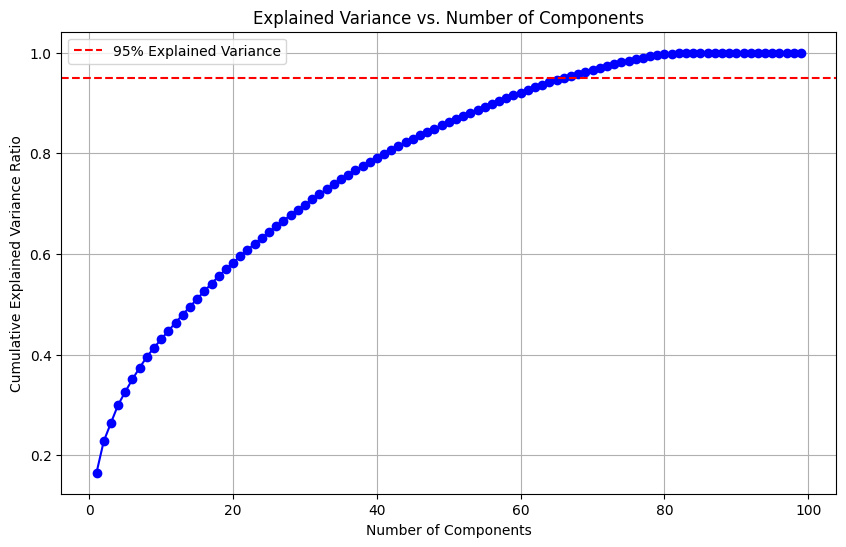

Number of components needed for 95% variance: 67


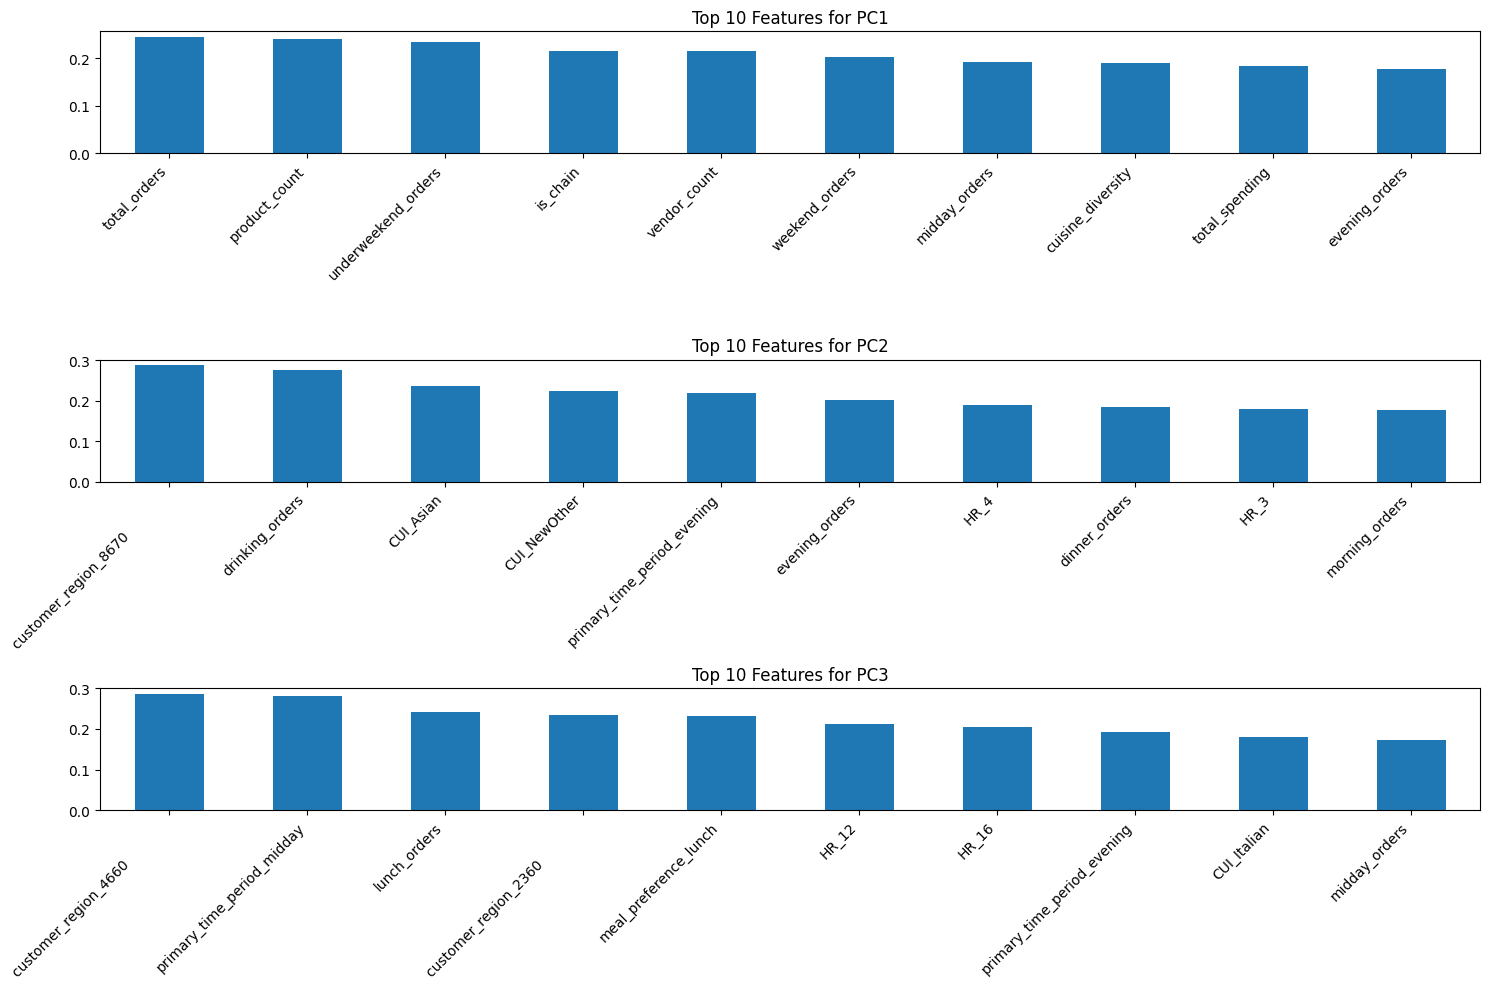

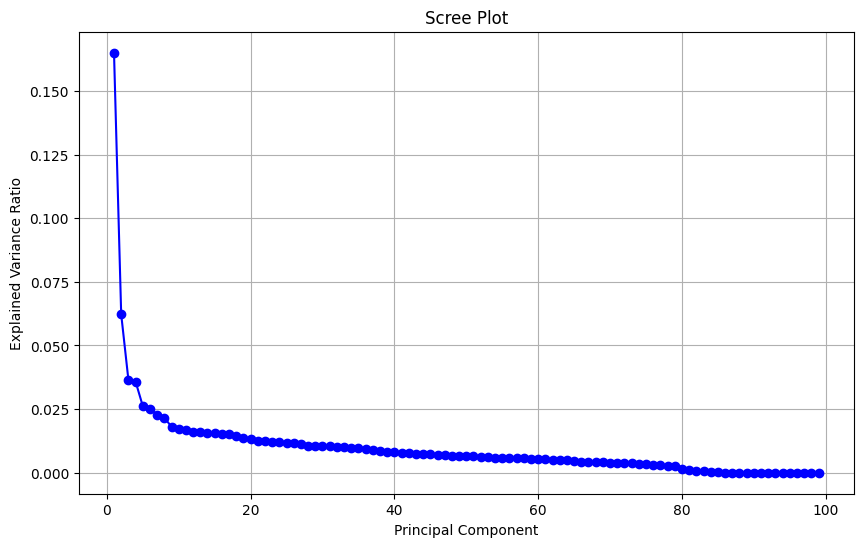


Variance explained by each principal component:


SyntaxError: 'return' outside function (4021228259.py, line 89)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use the scaled data we already have from earlier
scaled_data = scaled_df

# Initialize and fit PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Create figure for explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.grid(True)
plt.legend()
plt.show()

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components_95}")

# Get feature importance scores
component_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=scaled_df.columns
)

# Get top contributing features for first 3 principal components
n_top_features = 10
top_features = {}

for i in range(3):  # First 3 PCs
    pc = f'PC{i+1}'
    # Get absolute loadings
    abs_loadings = abs(component_loadings[pc])
    # Get top features
    top_features[pc] = abs_loadings.nlargest(n_top_features)

# Create figure for feature importance
plt.figure(figsize=(15, 10))
for i, (pc, features) in enumerate(top_features.items(), 1):
    plt.subplot(3, 1, i)
    features.plot(kind='bar')
    plt.title(f'Top {n_top_features} Features for {pc}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
plt.show()

# Create scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Perform PCA with optimal number of components
pca_optimal = PCA(n_components=n_components_95)
pca_transformed = pca_optimal.fit_transform(scaled_data)

# Create DataFrame with reduced features
pca_df = pd.DataFrame(
    pca_transformed,
    columns=[f'PC{i+1}' for i in range(n_components_95)],
    index=scaled_df.index
)

# Print variance explained by each component
print("\nVariance explained by each principal component:")
for i, var in enumerate(pca_optimal.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.4f} ({var*100:.2f}%)")

# Return the transformed data and the PCA object
    return pca_df, pca_optimal

# Clustering

In [59]:
#Select numeric data types
df_numeric = df.select_dtypes(include=[np.number])


In [60]:
#K-means with K=5 for numeric data types
kmclust = KMeans(n_clusters=5, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df_numeric)
km_labels = kmclust.fit_predict(df_numeric)

# Characterizing the final clusters
df_concat = pd.concat((df_numeric, pd.Series(km_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean()

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,total_spending,total_orders,cuisine_diversity,weekend_orders,underweekend_orders,weekend_ratio,lunch_orders,dinner_orders,morning_orders,midday_orders,evening_orders,night_orders,drinking_orders,CUI_NewAsian,CUI_NewOther
labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,27.499589,3.850662,6.613875,3.700319,15.197262,75.658969,5.268827,7.354633,2.196531,0.609493,1.082611,1.577453,0.621360,0.951346,1.914468,3.744774,2.962665,1.021999,3.485897,1.831766,0.997353,0.677042,0.669922,0.718759,0.755728,0.834322,0.814423,0.870014,0.049384,0.050023,0.060338,0.104427,0.090552,0.075673,0.060246,0.073756,0.134550,0.240621,0.352168,0.475673,0.426198,0.304701,0.265176,0.339845,0.454131,0.521132,0.471292,0.354267,0.212506,0.105705,0.063806,0.054039,35.621178,5.340210,2.827385,1.547056,3.793154,0.291700,1.206572,1.038065,0.861342,1.811593,2.013327,0.272935,0.381013,7.451940,5.259151
1,27.550893,1.780621,2.533493,1.288525,60.526896,72.775503,2.262027,4.944615,1.146025,0.267031,0.347435,0.533606,0.514841,0.484021,0.780507,1.653247,1.545320,0.260434,1.329012,1.915728,0.365063,0.234277,0.253383,0.257364,0.292847,0.364722,0.328898,0.329239,0.022518,0.023883,0.029000,0.072103,0.059479,0.042306,0.036393,0.039236,0.063573,0.114523,0.138292,0.167861,0.136245,0.105538,0.109291,0.147276,0.175480,0.184579,0.149210,0.106107,0.060844,0.033777,0.023883,0.019334,18.348914,2.060730,1.543501,0.563516,1.497214,0.274378,0.409644,0.316161,0.392016,0.666212,0.676220,0.099511,0.226771,3.224497,3.843626
2,27.633867,11.050343,34.070938,12.073227,7.114416,83.688787,24.572082,97.034325,14.938215,11.885584,1.633867,8.972540,8.112128,5.434783,7.965675,12.521739,20.354691,2.011442,17.425629,48.130435,3.745995,3.057208,3.290618,3.187643,3.276888,3.324943,2.961098,3.475973,0.386728,0.439359,0.588101,0.787185,0.812357,0.578947,0.585812,0.633867,1.064073,1.713959,2.372998,1.956522,1.338673,1.082380,1.027460,1.343249,1.567506,1.473684,1.041190,0.679634,0.455378,0.155606,0.208238,0.281465,284.739130,22.574371,4.679634,6.533181,16.041190,0.286057,4.377574,2.176201,6.370709,6.748284,5.217391,1.032037,3.205950,41.038902,83.066362
3,27.652005,6.482944,15.114004,6.326152,14.154698,78.516158,12.875524,33.842310,5.947337,2.690006,1.128965,4.011670,2.655296,2.771394,3.669360,8.052364,8.215739,1.201975,7.261819,15.449132,2.089767,1.451825,1.495212,1.547576,1.583184,1.578097,1.489527,1.633752,0.131957,0.165470,0.189707,0.358169,0.294434,0.253441,0.213645,0.235787,0.400359,0.716936,0.991921,0.918612,0.698384,0.555955,0.528127,0.693597,0.847995,0.864752,0.682825,0.463495,0.242071,0.121185,0.098743,0.111610,111.862657,10.779174,3.687612,3.085577,7.693597,0.289750,2.172950,1.388390,2.558648,3.394674,3.101137,0.463495,1.261221,17.986535,26.741771
4,27.375030,1.773812,2.502923,1.401583,18.528258,31.140317,2.282217,3.890012,1.220585,0.203410,0.424604,0.562241,0.419854,0.351279,0.819854,1.455420,1.211815,0.389890,1.269306,1.574421,0.354933,0.250305,0.254446,0.259927,0.263825,0.308526,0.332156,0.371255,0.024726,0.025944,0.025091,0.055055,0.047259,0.037759,0.032765,0.027527,0.044702,0.081486,0.131790,0.176005,0.149939,0.114373,0.096833,0.110840,0.161876,0.194762,0.186724,0.142631,0.083191,0.041535,0.025457,0.022168,16.429842,2.040438,1.561876,0.621559,1.418879,0.305229,0.440317,0.412546,0.318270,0.647990,0.769184,0.113886,0.191108,2.948843,3.418270


In [61]:
#5 Clusters Output
df_concat = pd.concat((df_numeric, pd.Series(km_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean()

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,total_spending,total_orders,cuisine_diversity,weekend_orders,underweekend_orders,weekend_ratio,lunch_orders,dinner_orders,morning_orders,midday_orders,evening_orders,night_orders,drinking_orders,CUI_NewAsian,CUI_NewOther
labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,27.499589,3.850662,6.613875,3.700319,15.197262,75.658969,5.268827,7.354633,2.196531,0.609493,1.082611,1.577453,0.621360,0.951346,1.914468,3.744774,2.962665,1.021999,3.485897,1.831766,0.997353,0.677042,0.669922,0.718759,0.755728,0.834322,0.814423,0.870014,0.049384,0.050023,0.060338,0.104427,0.090552,0.075673,0.060246,0.073756,0.134550,0.240621,0.352168,0.475673,0.426198,0.304701,0.265176,0.339845,0.454131,0.521132,0.471292,0.354267,0.212506,0.105705,0.063806,0.054039,35.621178,5.340210,2.827385,1.547056,3.793154,0.291700,1.206572,1.038065,0.861342,1.811593,2.013327,0.272935,0.381013,7.451940,5.259151
1,27.550893,1.780621,2.533493,1.288525,60.526896,72.775503,2.262027,4.944615,1.146025,0.267031,0.347435,0.533606,0.514841,0.484021,0.780507,1.653247,1.545320,0.260434,1.329012,1.915728,0.365063,0.234277,0.253383,0.257364,0.292847,0.364722,0.328898,0.329239,0.022518,0.023883,0.029000,0.072103,0.059479,0.042306,0.036393,0.039236,0.063573,0.114523,0.138292,0.167861,0.136245,0.105538,0.109291,0.147276,0.175480,0.184579,0.149210,0.106107,0.060844,0.033777,0.023883,0.019334,18.348914,2.060730,1.543501,0.563516,1.497214,0.274378,0.409644,0.316161,0.392016,0.666212,0.676220,0.099511,0.226771,3.224497,3.843626
2,27.633867,11.050343,34.070938,12.073227,7.114416,83.688787,24.572082,97.034325,14.938215,11.885584,1.633867,8.972540,8.112128,5.434783,7.965675,12.521739,20.354691,2.011442,17.425629,48.130435,3.745995,3.057208,3.290618,3.187643,3.276888,3.324943,2.961098,3.475973,0.386728,0.439359,0.588101,0.787185,0.812357,0.578947,0.585812,0.633867,1.064073,1.713959,2.372998,1.956522,1.338673,1.082380,1.027460,1.343249,1.567506,1.473684,1.041190,0.679634,0.455378,0.155606,0.208238,0.281465,284.739130,22.574371,4.679634,6.533181,16.041190,0.286057,4.377574,2.176201,6.370709,6.748284,5.217391,1.032037,3.205950,41.038902,83.066362
3,27.652005,6.482944,15.114004,6.326152,14.154698,78.516158,12.875524,33.842310,5.947337,2.690006,1.128965,4.011670,2.655296,2.771394,3.669360,8.052364,8.215739,1.201975,7.261819,15.449132,2.089767,1.451825,1.495212,1.547576,1.583184,1.578097,1.489527,1.633752,0.131957,0.165470,0.189707,0.358169,0.294434,0.253441,0.213645,0.235787,0.400359,0.716936,0.991921,0.918612,0.698384,0.555955,0.528127,0.693597,0.847995,0.864752,0.682825,0.463495,0.242071,0.121185,0.098743,0.111610,111.862657,10.779174,3.687612,3.085577,7.693597,0.289750,2.172950,1.388390,2.558648,3.394674,3.101137,0.463495,1.261221,17.986535,26.741771
4,27.375030,1.773812,2.502923,1.401583,18.528258,31.140317,2.282217,3.890012,1.220585,0.203410,0.424604,0.562241,0.419854,0.351279,0.819854,1.455420,1.211815,0.389890,1.269306,1.574421,0.354933,0.250305,0.254446,0.259927,0.263825,0.308526,0.332156,0.371255,0.024726,0.025944,0.025091,0.055055,0.047259,0.037759,0.032765,0.027527,0.044702,0.081486,0.131790,0.176005,0.149939,0.114373,0.096833,0.110840,0.161876,0.194762,0.186724,0.142631,0.083191,0.041535,0.025457,0.022168,16.429842,2.040438,1.561876,0.621559,1.418879,0.305229,0.440317,0.412546,0.318270,0.647990,0.769184,0.113886,0.191108,2.948843,3.418270


In [63]:
#K-means with numeric features finding the best number of clusters

range_clusters = range(1, 11)

inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_numeric)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d80cf8a3-0707-4865-ba36-9382bf28b032' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>